#1. Drive Mount

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls -al '/gdrive/My Drive/autonomous_data/black_box/video'

total 71963
-rw------- 1 root root 24769178 Sep 24 08:53 highway_road_2_down.mp4
-rw------- 1 root root 24088654 Sep 24 09:20 highway_road_3_down.mp4
-rw------- 1 root root 24831054 Sep 24 09:20 highway_road_4_down.mp4


In [3]:
# Import python library
import cv2
import numpy as np
import IPython
import math
from google.colab.patches import cv2_imshow

In [4]:
file_name = '/gdrive/My Drive/autonomous_data/black_box/video/highway_road_2_down.mp4'

In [5]:
# initialize the video writer 
writer = None
output_name = 'lane_detection.avi'

In [6]:
# parameter
kernel_size = 5
low_threshold = 50
high_threshold = 130
rho = 2
theta = np.pi / 180
threshold = 20
min_line_len = 10
max_line_gap = 50

In [8]:
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

In [9]:
def graysacle(frame):
    # Conver the image to graysacle
    return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

In [10]:
def to_gaussianblur(frame, kernel_size):
    # GaussianBlur for refucing noise
    return cv2.GaussianBlur(frame, (kernel_size, kernel_size), 0)

In [11]:
def to_canny(frame, low_threshold, high_threshold):
    # Canny Edge detection
    return cv2.Canny(frame, low_threshold, high_threshold)

In [12]:
def region_of_interest(frame):

    height, width = frame.shape[:2]
    mask = np.zeros((height,width), dtype='uint8')
    poly_heigh = int(0.715 * height)
    poly_left = int(0.495 * width)
    poly_right = int(0.545 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    polygons = np.array([[(poly_left_bottom, poly_bottom), (poly_left, poly_heigh), (poly_right, poly_heigh), (poly_right_bottom, poly_bottom)]])

    #frame = cv2.polylines(frame, [polygons], True, (255,0,0), 2)

    cv2.fillPoly(mask, polygons, 255)
    # Bitwise operation between poly and mask
    return cv2.bitwise_and(frame, mask)

In [13]:
def hough_lines(frame, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(frame, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

In [14]:
def draw_lines(frame, lines, color=[255,0,0], thickness=8):

    height, width = frame.shape[:2]
    longest_left_line_len = 0
    longest_right_line_len = 0
    longest_left_line = (0,0,0,0)
    longest_right_line = (0,0,0,0)
    long_left_line_m = 0
    long_right_line_m = 0
    long_left_intercept = 0
    long_right_intercept = 0

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)

            slope = ((y2-y1)/(x2-x1))
            line_length = math.sqrt((x1-x2)**2 + (y1-y2)**2)

            if slope > 0.2:
                if (line_length > longest_right_line_len):
                    longest_right_line_len = line_length
                    longest_right_line = (x1, y1, x2, y2)
                    long_right_line_m = ((longest_right_line[1]-longest_right_line[3])/(longest_right_line[0]-longest_right_line[2]))
                    long_right_intercept = longest_right_line[3]-(long_right_line_m * longest_right_line[2])

            elif slope < -0.2: 
                if (line_length > longest_left_line_len):
                    longest_left_line_len = line_length
                    longest_left_line = (x1, y1, x2, y2)
                    long_left_line_m = ((longest_left_line[1]-longest_left_line[3])/(longest_left_line[0]-longest_left_line[2]))
                    long_left_intercept = longest_left_line[3]-(long_left_line_m * longest_left_line[2])
            #cv2.line(frame, (x1,y1), (x2,y2), (0,0,255), 1)
            print(slope, long_left_line_m, long_right_line_m)
    
    left_lane_bottom_xy = [0,0]
    left_lane_top_xy = [0,0]
    right_lane_bottom_xy = [0,0]
    right_lane_top_xy = [0,0]

    left_lane_bottom_xy[1] = height  # Y coordinate
    left_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_left_intercept)/long_left_line_m

    left_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
    left_lane_top_xy[0] = (left_lane_top_xy[1]-long_left_intercept)/long_left_line_m  # X 

    right_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
    right_lane_top_xy[0] = (right_lane_top_xy[1]-long_right_intercept)/long_right_line_m

    right_lane_bottom_xy[1] = height  # Y coordinate
    right_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_right_intercept)/long_right_line_m

    cv2.line(frame, (int(left_lane_bottom_xy[0]), int(left_lane_bottom_xy[1])), (int(left_lane_top_xy[0]), int(left_lane_top_xy[1])), (0,0,255), 10)
    cv2.line(frame, (int(right_lane_bottom_xy[0]), int(right_lane_bottom_xy[1])), (int(right_lane_top_xy[0]), int(right_lane_top_xy[1])), (0,0,255), 10)



In [15]:
def detectionAndDisplay(frame):
    IPython.display.clear_output(wait=True)
    # Conver the image to grayscale
    gray = graysacle(frame)
    height, width = gray.shape
    # GaussianBlur for refucig noise
    blur = to_gaussianblur(gray, kernel_size)
    # Canny Edge detection
    canny = to_canny(blur, low_threshold, high_threshold)
    masked = region_of_interest(canny)
    
    # hough_line
    lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)

    draw_lines(frame, lines)

    cv2_imshow(frame)
    writeFrame(frame)
    

In [16]:
def check_ROI(frame):
    IPython.display.clear_output(wait=True)
    
    height, width = frame.shape[:2]
    mask = np.zeros((height,width), dtype='uint8')
    poly_heigh = int(0.715 * height)
    poly_left = int(0.49 * width)
    poly_right = int(0.545 * width)
    poly_bottom = int(0.945 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    polygons = np.array([[(poly_left_bottom, poly_bottom), (poly_left, poly_heigh), (poly_right, poly_heigh), (poly_right_bottom, poly_bottom)]])

    frame = cv2.polylines(frame, [polygons], True, (255,0,0), 2)

    cv2_imshow(frame)
    writeFrame(frame)

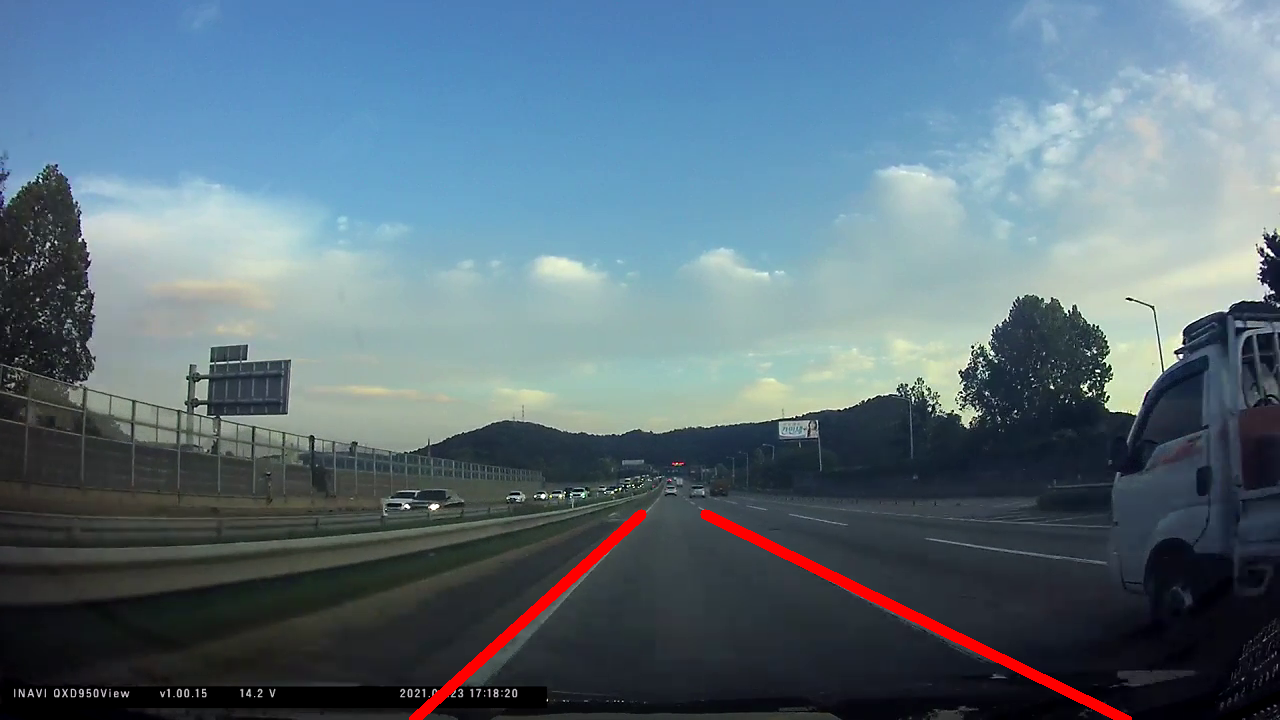

--(!) No captured frame -- Break!


In [ ]:
cap = cv2.VideoCapture(file_name)

if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)

while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break   
    #check_ROI(frame2)
    detectionAndDisplay(frame)  
    

In [31]:
from google.colab import files
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>